# Generate Figures for Word2Vec Year Models

The goal of this notebook is to observe how words are shifting through time since 2005. The year 2005 was selected as this is the only year the word 'CRISPR' appears in the Word2Vec models. This highlights the catch with Word2Vec models as they require words to appear at a given frequency within abstracts to be captured by the model.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from msp_tsne import MultiscaleParametricTSNE
import tensorflow as tf
from tensorflow import keras

from biovectors_modules.plot_helper import (
    plot_token_timeline,
    plot_local_global_distances,
    plot_wordcloud_neighbors,
    plot_wordcloud_neighbors_gif,
)
from biovectors_modules.word2vec_analysis_helper import (
    generate_timeline,
    get_neighbors,
    project_token_timeline,
    window,
)

Using TensorFlow backend.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

# Load Models to Observe Changes

In [2]:
aligned_models = pickle.load(open("output/aligned_word_vectors_2005_2020.pkl", "rb"))

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (list(Path("output/year_distances_2005_2020").rglob("*tsv")))
}
list(year_comparison_dict.keys())[0:3]

['2005_2006', '2019_2020', '2016_2017']

In [4]:
year_comparison_dict["2005_2006"].sort_values("global_dist")

,token,global_dist,local_dist,shift
9356,countrywide,0.806431,0.585713,0.220718
10246,deliberative,0.808832,0.636203,0.172629
25384,principal,0.816737,0.737316,0.079421
23918,perfection,0.818079,0.677719,0.140360
18138,jordan,0.818302,0.669229,0.149073
...,...,...,...,...
30096,subtracting,1.205301,1.396194,-0.190894
1944,400,1.205314,1.371494,-0.166180
18215,kampo,1.211756,1.380307,-0.168551
1883,4.3,1.216479,1.377546,-0.161066


## Train TSNE Model to Project Time Shifts into Two Dimensional Space

The goal here is to train a TSNE model that projects all words from 2005 to 2020 into a two dimensional space. Allows one to visually track how a word vector is shifting through time.

In [5]:
word_models_stacked = np.vstack(list(aligned_models.values())[:-1])
file_name = "output/2005_2020_model.h5"

In [6]:
if not Path(file_name).exists():
    tf.random.set_random_seed(100)
    np.random.seed(100)
    model = MultiscaleParametricTSNE(n_iter=300)
    model.fit(word_models_stacked)
    keras.models.save_model(model._model, file_name)
else:
    model = MultiscaleParametricTSNE(n_iter=300)
    model._build_model(300, 2)
    model._model.load_weights(file_name)

# Visualize Words Shifting through Time

This section is the same analysis mentioned in [03_word_decade_figure_generator_2000_2020.ipynb](03_word_decade_figure_generator_2000_2020.ipynb). The basic idea is to see how CRISPR shifts through time.

## CRISPR

In [7]:
token_timeline_df = generate_timeline(year_comparison_dict, "crispr")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
9497,crispr,1.020169,1.082887,-0.062718,2005_2006
9497,crispr,0.418030,0.096855,0.321175,2019_2020
9497,crispr,0.491679,0.152805,0.338875,2016_2017
9497,crispr,0.527278,0.068482,0.458796,2007_2008
9497,crispr,0.416767,0.081120,0.335647,2018_2019


In [8]:
token_timeline_low_dim_df = project_token_timeline(
    "crispr", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,-1.631946,0.286493,2020,crispr,main
1,-1.906295,0.126452,2020,rnai,neighbor
2,-2.173041,-0.366214,2020,cas,neighbor
3,-2.310347,-0.307655,2020,nucleases,neighbor
4,-2.791123,-1.174983,2020,editing,neighbor


In [9]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="crispr"
)

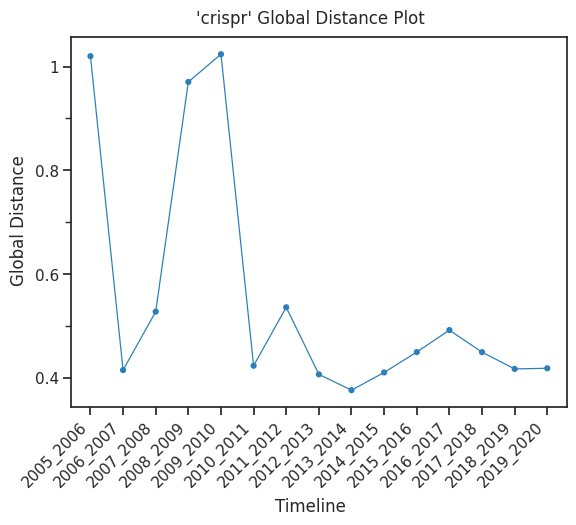

<ggplot: (8759467578930)>

In [10]:
global_distance

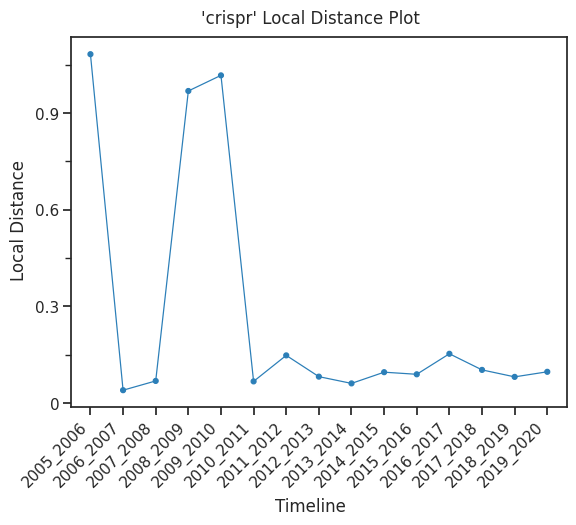

<ggplot: (-9223363277387198085)>

In [11]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/crispr_time_plot.png


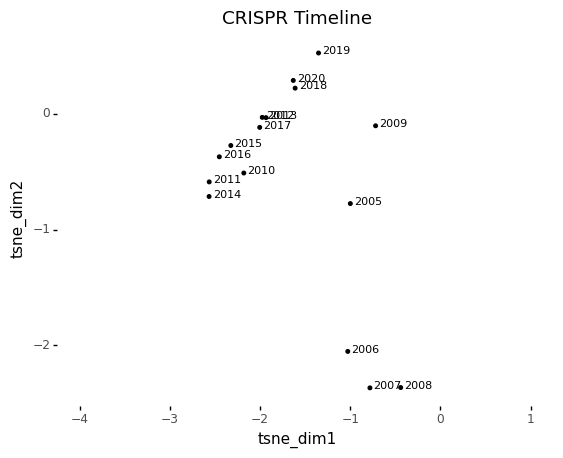

<ggplot: (8759467457393)>


In [12]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/crispr_time_plot.png")
print(g)

In [15]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2005_2020/crispr.gif",
)

![crispr gif here](output/wordcloud_plots_2005_2020/crispr.gif)

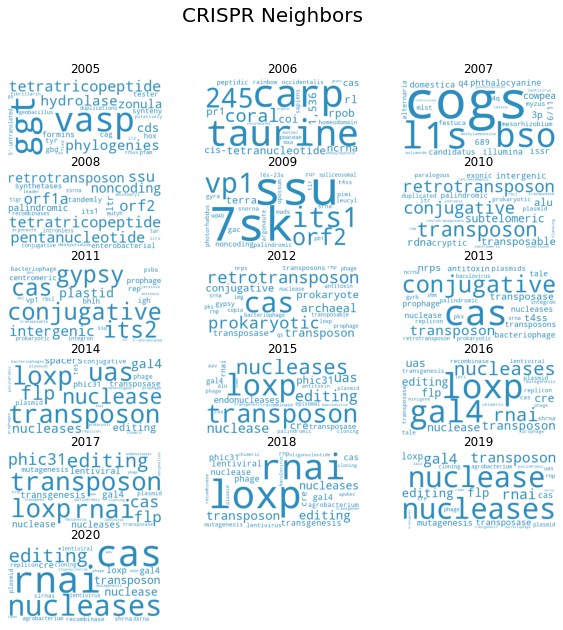

In [16]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2005_2020/crispr.png",
)

# Conclusions - Take Home Point(s)

1. CRISPR has a nice transition from microbiology to genome editing. Word cloud neighbors does wonders in observing this transition.